## This file mitigates the problem of distribution shift shown in y_test_2_reduced.csv

## 1. Load Libraries and datasets

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split

# Load resampled training data
X = pd.read_csv("Data/X_train.csv")
y = pd.read_csv("Data/y_train.csv")

# Load Test Set 2 and its reduced labels
X_test_2 = pd.read_csv("Data/X_test_2.csv")
y_test_2 = pd.read_csv("Data/y_test_2_reduced.csv")

## 2. Diagnose the problem

/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_81777/2178695760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels["label"], palette='Blues', order=sorted(train_labels["label"].unique()))


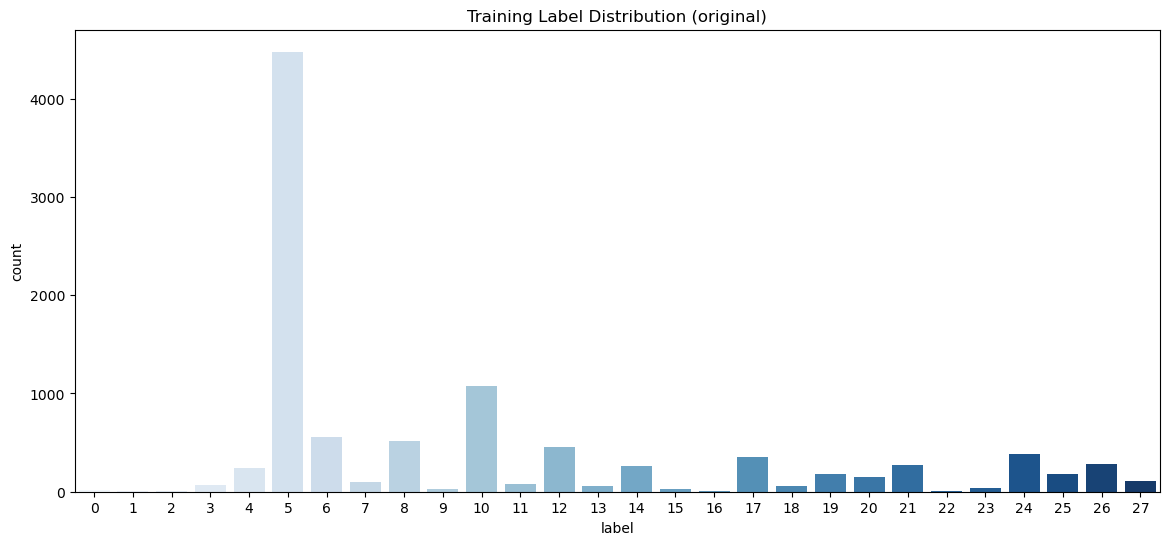

/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_81777/2178695760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels["label"], palette='Reds', order=sorted(test_labels["label"].unique()))


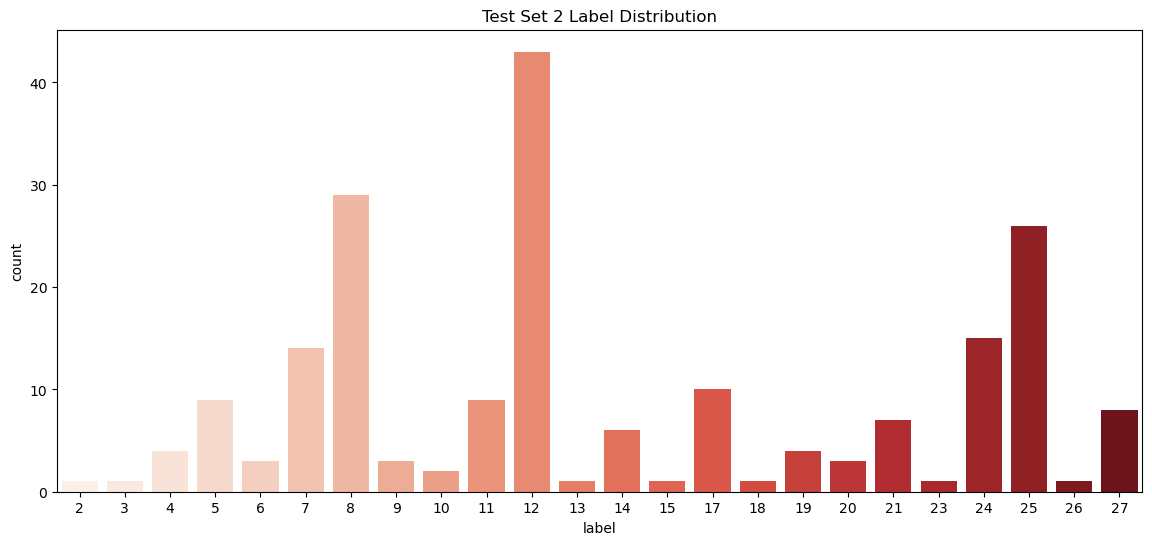

KL Divergence between test2 and train label distributions: 0.9445


In [14]:
def plot_label_distribution(train_labels, test_labels):
    plt.figure(figsize=(14, 6))
    sns.countplot(x=train_labels["label"], palette='Blues', order=sorted(train_labels["label"].unique()))
    plt.title("Training Label Distribution (original)")
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.countplot(x=test_labels["label"], palette='Reds', order=sorted(test_labels["label"].unique()))
    plt.title("Test Set 2 Label Distribution")
    plt.show()

plot_label_distribution(y, y_test_2)

# KL divergence between label distributions
def compute_kl_divergence(train_labels, test_labels):
    train_dist = train_labels['label'].value_counts(normalize=True).sort_index()
    test_dist = test_labels['label'].value_counts(normalize=True).sort_index()
    all_classes = sorted(set(train_dist.index).union(set(test_dist.index)))
    train_probs = [train_dist.get(c, 1e-10) for c in all_classes]
    test_probs = [test_dist.get(c, 1e-10) for c in all_classes]
    kl_div = entropy(test_probs, train_probs)
    print(f"KL Divergence between test2 and train label distributions: {kl_div:.4f}")

compute_kl_divergence(y, y_test_2)

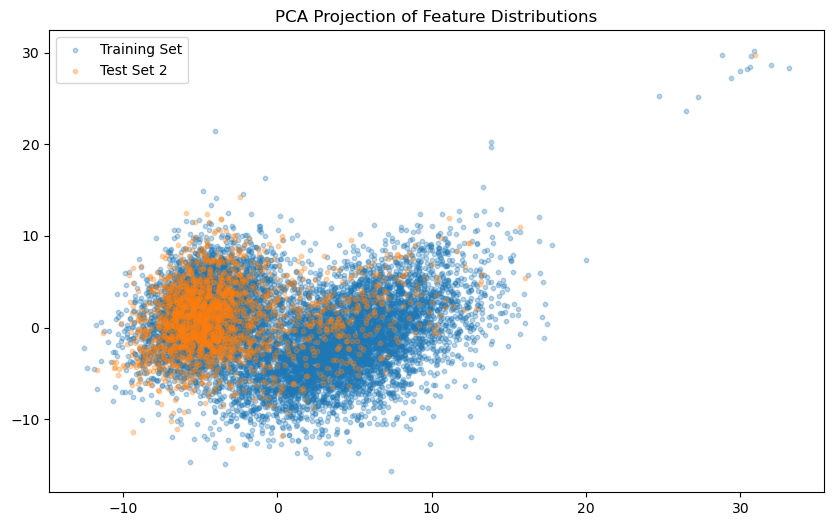

In [15]:
# PCA to visualize feature distribution
def plot_pca_feature_shift(X1, X2, label):
    pca = PCA(n_components=2)
    all_data = pd.concat([X1, X2])
    reduced = pca.fit_transform(all_data)

    X1_reduced = reduced[:len(X1)]
    X2_reduced = reduced[len(X1):]

    plt.figure(figsize=(10, 6))
    plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], alpha=0.3, label='Training Set', s=10)
    plt.scatter(X2_reduced[:, 0], X2_reduced[:, 1], alpha=0.3, label='Test Set 2', s=10)
    plt.title('PCA Projection of Feature Distributions')
    plt.legend()
    plt.show()

plot_pca_feature_shift(X, X_test_2, label='Feature Shift')

## 3. Random Forest on Resampled Training Set

In [24]:
# Load resampled training set
X_train = pd.read_csv('Data/resampled_X_train.csv')  
y_train = pd.read_csv('Data/resampled_y_train.csv')['label']

# Load labeled test2 set
X_test2 = pd.read_csv('Data/X_test_2.csv')  
X_test2_labeled = X_test2.iloc[:202]
X_test2_unlabeled = X_test2.iloc[202:]
y_test2 = pd.read_csv('Data/y_test_2_reduced.csv')['label']

# Encode string labels as integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test2_enc = le.transform(y_test2)
n_classes = len(le.classes_)

# Train classifier
clf = RandomForestClassifier(class_weight=None, random_state=42)
clf.fit(X_train, y_train_enc)

# Predict class probabilities (for cross-entropy loss)
y_pred_proba = clf.predict_proba(X_test2_labeled)

# One-hot encode y_test2
y_true_ohe = np.zeros((len(y_test2_enc), n_classes))
y_true_ohe[np.arange(len(y_test2_enc)), y_test2_enc] = 1

# Compute class frequency
class_counts = np.sum(y_true_ohe, axis=0)

# Avoid divide-by-zero
nonzero_mask = class_counts > 0
safe_class_counts = class_counts[nonzero_mask]
safe_class_weights = 1.0 / safe_class_counts
safe_class_weights /= np.sum(safe_class_weights)

# Broadcast weights back to all classes (fill 0 for unseen ones)
class_weights = np.zeros_like(class_counts, dtype=float)
class_weights[nonzero_mask] = safe_class_weights

# Compute sample weights and loss as before
sample_weights = np.sum(y_true_ohe * class_weights, axis=1)
loss = -np.mean(sample_weights * np.sum(y_true_ohe * np.log(y_pred_proba + 1e-12), axis=1))

print("Weighted Cross-Entropy Loss on labeled test2:", loss)

present_labels = np.array(sorted(np.unique(y_test2_enc)))  # Ensure it's a NumPy array
present_label_names = [str(label) for label in le.inverse_transform(present_labels)]  # Convert to strings

print(classification_report(
    y_test2_enc,
    np.argmax(y_pred_proba, axis=1),
    labels=present_labels,
    target_names=present_label_names,
    digits=3
))

Weighted Cross-Entropy Loss on labeled test2: 0.02537045084760929
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         1
           4      0.267     1.000     0.421         4
           5      0.667     0.444     0.533         9
           6      0.500     1.000     0.667         3
           7      0.889     0.571     0.696        14
           8      0.727     0.828     0.774        29
           9      0.000     0.000     0.000         3
          10      0.250     1.000     0.400         2
          11      0.692     1.000     0.818         9
          12      0.850     0.395     0.540        43
          13      0.333     1.000     0.500         1
          14      0.333     0.500     0.400         6
          15      0.000     0.000     0.000         1
          17      0.700     0.700     0.700        10
          18      0.000     0.000     0.000         1
          19   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
